<center>

# Evaluating Spatial Accessibility and Social Equity of Urban Public Facilities: A Case Study in New York City

## Final Project: ST445-Managing and Visualizing Data, 24/25

### Candidates: 45293, 

</center>


## Prerequisites of Notebook

TODO

1. Python>=3.10
2. Install the latest Geopandas package

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sodapy import Socrata
from shapely.geometry import shape
import osmnx as ox
import shapely
from shapely.geometry import LineString
from shapely.ops import snap, linemerge
from census import Census
from us import states
import numpy as np
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
ox.settings.use_cache = False
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## Content <br><br>

* [**1. Introduction**](#1)
    * [1.1 Research Background](#1_1)
    * [1.2 Research Objectives and Questions](#1_2)
    * [1.3 Description of Dataset](#1_3)
* [**2. Data Acquisiton and Preprocessing**](#2)
    * [2.1 The Boundaries of NYC by Boroughs and Census Tracts](#2_1)
    * [2.2 Roads and Paths in NYC](#2_2)
    * [2.3 Geographical Points of Public Facilities](#2_3)
    * [2.4 Socio-economic Indicators from ACS](#2_4)
    * [2.5 Other Indicators Generated by Current Acquired Data](#2_5)
* [**3. Data Visualization and Analysis**](#3)
    * [3.1 Spatial Accessibility Distribution of Different Public Facilities](#3_1)
    * [3.2 Equity Assessment of Different Boroughs](#3_2)
    * [3.3 Equity Assessment of Different Demographic Groups](#3_3)
    * [3.4 Evaluation of Socio-economic Factors’ Impact on Facility Accessibility](#3_4)
* [**4. Conclusion**](#4)
* [**References**](#5)

<a id="1"></a>
## **1. Introduction**


<a id="1_1"></a>
### 1.1 Research Background

In recent years, urban areas worldwide have experienced rapid and high-quality development, especially in cities' physical infrastructure, public facilities, and residents' quality of life. According to predictions by the **United Nations**, 68% of the global population will be living in urban areas by 2050 ( *United Nations, 2018* ). However, as cities continue to grow and expand, the concentration of wealth and income growth among the highest earners will exacerbate economic inequalities, leading to more intense competition for limited urban resources ( *Sarkar et al., 2024* ). This indicates that urban development has to face the dilemma of inequality of public resources, including public facilities such as education, medical care, transportation, cultural & historical sites, and so on ( *Xu et al., 2022* ).

Hence, it is of great research importance to:

- Quantify the accessibility levels of multiple public facilities and analyze their spatial distribution patterns.
- Assess the equity levels of various facilities based on different geographical locations and demographic groups.
- Evaluate the impacts of various socio-economic factors on the accessibility levels of public facilities.

Such research can assist policymakers and urban planners in identifying spatial and demographic disparities in public resource access, understanding the underlying mechanisms and contributing indicators of these inequalities, and ultimately promoting **social justice** as well as the long-term **sustainable city development**.

<a id="1_2"></a>
### 1.2 Research Objectives and Questions

Based on the research context, this project aims to conduct a comprehensive analysis of equitable access to two types of public facilities (education and health care) in New York City (NYC) on a ["census tract"](https://en.wikipedia.org/wiki/Census_tract) scale. NYC is the largest city in the U.S. with substantial metropolitan economy and diverse demographic composition (*Baghestani et al., 2024*), which make it an ideal choice to be selected as the study area for our analysis. The study also seeks to provide meaningful insights into the spatial and statistical characteristics of accessibility scores and the (in)equality status for both facilities, and to investigate how different socio-economic factors contribute to their accessibility patterns in NYC. To achieve these objectives, the research will be organized into three parts, each answering specific research questions as follows:

**Facility accessibility-based spatial distribution analysis:**  
- What is the spatial distribution of accessibility to different types of public facilities across all census tracts in NYC? 
- What are the overall geographical and numerical patterns of these accessibility levels/scores?

**Equity assessment across different NYC boroughs and population groups:**  
- Is the distribution of accessibility to different facilities equitable across all "boroughs" of NYC? In other words, is access to specific public facilities fairly distributed among all the "five" boroughs in NYC?
- Is the accessibility equitable across different "demographic groups" (e.g., by race or income level)? Do demographic groups of different races and personal incomes have equal access to the same public facilities?

**Importance assessment of relevant factors:**  
- What is the contribution or importance level of various socio-economic factors (e.g., population density, income, transportation access, poverty levels, facility density) to the accessibility of different public facilities?
- Does the importance ranking of these selected factors vary across different types of public facilities in influencing their accessibility levels?

<a id="1_3"></a>
### 1.3 Description of Dataset

This project acquires and utilizes multiple open-source datasets, including **points of interest (POI)** data with geographical coordinates, geospatial data such as **district polygons** and **traffic lines**, and **tabular data** containing socio-economic indicators. A summary of the datasets used in this research is demonstrated in the table below:

### Quick Infomation about the Dataset
|No.|Name|Data Type|Source|Data Processing Format|Data Access Method|
|---|---|---|---|---|---|
|1|POIs of NYC Public Facilities|Geographical points|[Facilities Database, NYC OpenData](https://data.cityofnewyork.us/City-Government/Facilities-Database/ji82-xba5/about_data)|GeoDataFrame|[Socrata Open Data API (SODA)](https://dev.socrata.com/)|
|2|NYC Borough Boundaries|Spatial vector data (polygon)|[Borough Boundaries, NYC OpenData](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)|GeoDataFrame|[Socrata Open Data API (SODA)](https://dev.socrata.com/)|
|3|NYC Latest Census Tracts Boundaries|Spatial vector data (polygon)|[2020 Census Tracts, NYC OpenData](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts/63ge-mke6/about_data)|GeoDataFrame|[Socrata Open Data API (SODA)](https://dev.socrata.com/)|
|4|Roads and Paths of NYC|Spatial vector data (line)|[Open Street Map](https://www.openstreetmap.org/#map=12/40.7902/-73.9184)|GeoDataFrame|[OSMnx Python Package](https://osmnx.readthedocs.io/en/stable/getting-started.html)
|5|Socio-economic Indicators|Tabular data|[American Community Survey 5-Year Data](https://www.census.gov/data/developers/data-sets/acs-5year.html)|DataFrame|[U.S. Census Data API](https://www.census.gov/data/developers/guidance/api-user-guide.html)|
|6|Other Indicators|Data frame with geometry|Produced from the data 1-5|GeoDataFrame|Obtained by post-processing acquired data above|

#### Data Description & Usage

**The NYC boundaries data:**
- The borough boundaries data is used to interact with the census tracts
- The census tracts boundaries data is used to

**NYC Open Street Map (OSM) Roads and path data:**
- The roads and paths spatial line data from OSM contain various traffic and residential line features such as major/minor city roads, residential paths, busways, and so on.

**Facility POIs:**

**American Community Survey (ACS) socio-economic data:**

**Other indicators generated by the above accessed data:**


<a id="2"></a>
## **2. Data Acquisiton and Preprocessing**


<a id="2_1"></a>
### 2.1 The Boundaries of NYC by Boroughs and Census Tracts

#### Quick tutorial about acquiring data from the [NYC OpenData](https://opendata.cityofnewyork.us/)



#### [The Boundaries of Boroughs in NYC](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm)



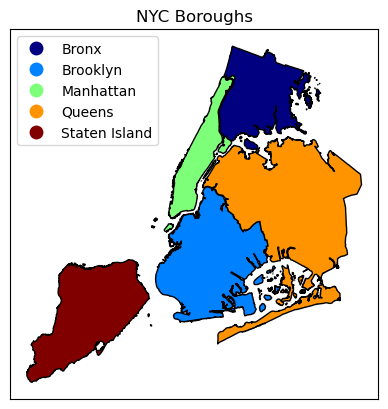

In [3]:
# TODO: kMA3pLN5r66BAnhG4hQvEr8Mi is my own token
client = Socrata("data.cityofnewyork.us", "kMA3pLN5r66BAnhG4hQvEr8Mi")


# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("7t3b-ywvw")

# Convert to pandas DataFrame
NYC_borough = pd.DataFrame.from_records(results)

NYC_borough = NYC_borough[NYC_borough["the_geom"].notnull()]

# Convert the_geom as Shapely Geometric Objects
NYC_borough["geometry"] = NYC_borough["the_geom"].apply(lambda x: shape(x))

# TODO: CRS description
NYC_borough = gpd.GeoDataFrame(NYC_borough, geometry="geometry", crs="EPSG:4326")
NYC_borough = NYC_borough.to_crs(epsg=32618)
NYC_borough = NYC_borough.drop(columns=["the_geom", "shape_leng", "shape_area"])
NYC_borough["Area (km2)"] = NYC_borough.geometry.area/1000000
NYC_borough.plot(column="boro_name", legend=True, cmap = "jet", edgecolor="black", legend_kwds={"loc": "upper left"})
plt.title("NYC Boroughs")
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
NYC_borough

,boro_code,boro_name,geometry,Area (km2)
0,5,Staten Island,"MULTIPOLYGON (((580375.284 4491060.737, 580378...",150.736531
1,1,Manhattan,"MULTIPOLYGON (((583578.458 4504203.877, 583494...",59.110787
2,2,Bronx,"MULTIPOLYGON (((593066.658 4516675.698, 593055...",110.230426
3,3,Brooklyn,"MULTIPOLYGON (((596200.035 4493185.981, 596154...",179.579251
4,4,Queens,"MULTIPOLYGON (((599306.991 4493965.116, 599308...",282.402362


#### [The Boundaries of Census Tracts in NYC](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts/63ge-mke6/about_data)

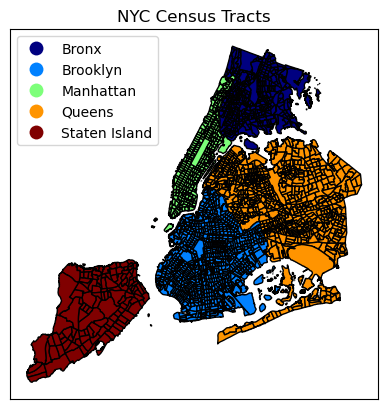

In [5]:
# TODO: kMA3pLN5r66BAnhG4hQvEr8Mi is my own token
client = Socrata("data.cityofnewyork.us", "kMA3pLN5r66BAnhG4hQvEr8Mi")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("63ge-mke6", limit=3000)

# Convert to pandas DataFrame
NYC_census_tract = pd.DataFrame.from_records(results)

NYC_census_tract = NYC_census_tract[NYC_census_tract["the_geom"].notnull()]

NYC_census_tract["geometry"] = NYC_census_tract["the_geom"].apply(lambda x: shape(x))

# TODO: CRS description
NYC_census_tract = gpd.GeoDataFrame(NYC_census_tract, geometry="geometry", crs="EPSG:4326")
NYC_census_tract = NYC_census_tract.to_crs(epsg=32618)
NYC_census_tract = NYC_census_tract.drop(columns=["the_geom", "ctlabel", "ct2020", "boroct2020", "ntaname", "nta2020", "cdta2020", "cdtaname", "shape_leng", "shape_area"])
NYC_census_tract["Area (km2)"] = NYC_census_tract.geometry.area/1000000
NYC_census_tract.plot(column="boroname", legend=True, cmap = "jet", edgecolor="black", legend_kwds={"loc": "upper left"})
plt.title("NYC Census Tracts")
plt.xticks([])
plt.yticks([])

plt.show()

<a id="2_2"></a>
### 2.2 Roads and Paths in NYC

#### Step 1: Get NYC road data from OSM

In [6]:
# It will take more than 3 minutes to run this cell
G = ox.graph_from_place('New York City, New York, USA')

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)


highway_types = ["motorway", "trunk", "primary", "secondary", "tertiary", "residential", "busway"]

NYC_road = gdf_edges[gdf_edges["highway"].apply(
    lambda x: isinstance(x, str) and x in highway_types
)]
NYC_road.head()

osmid    highway  oneway reversed      length  \
u        v          key                                                       
39076461 274283981  0      25161349   motorway    True    False  819.501666   
39076490 277672005  0    1014007069   motorway    True    False  291.838695   
39076504 462122450  0     995490141   motorway    True    False  552.425691   
42421728 7784826657 0     195743153  secondary   False     True   11.805821   
         7784826658 0     420625573  secondary   False    False   11.769534   

                                                                  geometry  \
u        v          key                                                      
39076461 274283981  0    LINESTRING (-73.79475 40.78635, -73.79462 40.7...   
39076490 277672005  0    LINESTRING (-73.75709 40.76243, -73.75741 40.7...   
39076504 462122450  0    LINESTRING (-73.74416 40.75347, -73.74552 40.7...   
42421728 7784826657 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         7784826658 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   

                                         name lanes maxspeed  ref bridge  \
u        v          key                                                    
39076461 274283981  0    Cross Island Parkway     2   50 mph   CI    NaN   
39076490 277672005  0    Cross Island Parkway     3   50 mph   CI    NaN   
39076504 462122450  0    Cross Island Parkway     3   50 mph   CI    NaN   
42421728 7784826657 0       Central Park West   NaN   25 mph  NaN    NaN   
         7784826658 0       West 106th Street   NaN      NaN  NaN    NaN   

                        access service tunnel width junction est_width area  \
u        v          key                                                       
39076461 274283981  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
39076490 277672005  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
39076504 462122450  0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
42421728 7784826657 0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   
         7784826658 0      NaN     NaN    NaN   NaN      NaN       NaN  NaN   

                        landuse  
u        v          key          
39076461 274283981  0       NaN  
39076490 277672005  0       NaN  
39076504 462122450  0       NaN  
42421728 7784826657 0       NaN  
         7784826658 0       NaN

#### Step 2: Select necessary columns

In [7]:
NYC_road = NYC_road[['osmid', 'highway', 'geometry', 'name']]
NYC_road = NYC_road.reset_index(drop=True)
NYC_road.head()

,osmid,highway,geometry,name
0,25161349,motorway,"LINESTRING (-73.79475 40.78635, -73.79462 40.7...",Cross Island Parkway
1,1014007069,motorway,"LINESTRING (-73.75709 40.76243, -73.75741 40.7...",Cross Island Parkway
2,995490141,motorway,"LINESTRING (-73.74416 40.75347, -73.74552 40.7...",Cross Island Parkway
3,195743153,secondary,"LINESTRING (-73.96004 40.79805, -73.96011 40.7...",Central Park West
4,420625573,secondary,"LINESTRING (-73.96004 40.79805, -73.96017 40.7...",West 106th Street


#### Step 3: Geo-referencing & Simplifyinhg the Lines

In [8]:
# Georeferencing
NYC_road = NYC_road.set_crs(epsg=4326)
NYC_road = NYC_road.to_crs(epsg=32618)

# Simplify the geometry
tolerance = 10
NYC_road['geometry'] = NYC_road['geometry'].simplify(tolerance)

# NYC_road.to_file('D:/Download/NYC_road.geojson', driver='GeoJSON')

NYC_road.head()

,osmid,highway,geometry,name
0,25161349,motorway,"LINESTRING (601691.23 4515738.523, 602148.812 ...",Cross Island Parkway
1,1014007069,motorway,"LINESTRING (604906.239 4513128.015, 604814.414...",Cross Island Parkway
2,995490141,motorway,"LINESTRING (606011.533 4512148.657, 605866.196...",Cross Island Parkway
3,195743153,secondary,"LINESTRING (587729.044 4516859.09, 587723.438 ...",Central Park West
4,420625573,secondary,"LINESTRING (587729.044 4516859.09, 587718.659 ...",West 106th Street


<Axes: >

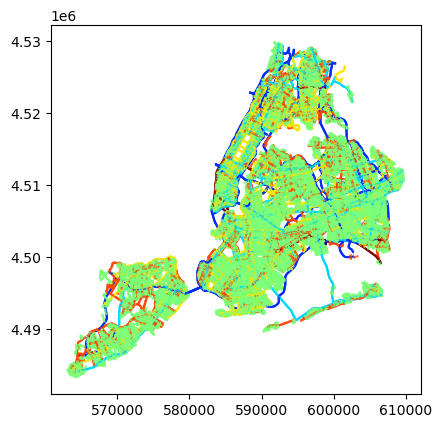

In [9]:
NYC_road.plot(column="highway", cmap="jet")

<a id="2_3"></a>
### 2.3 [Geographical Points of Public Facilities](https://data.cityofnewyork.us/City-Government/Facilities-Database/ji82-xba5/about_data)

#### Selected Points of Intrests (POIs)

- **Education**
Education, Child Welfare, and Youth:
    Schools (K-12)
    Higher Education
    Vocational and Proprietary Schools

- **Parks, Gardens and Cultural Sites**
Parks, Gardens, and Historical Sites +
Libraries and Cultural Programs

- **Health**
Health and Human Services
    Health Care

- **Public Safety**
Public Safety
    Emergency Services
    Public Safety

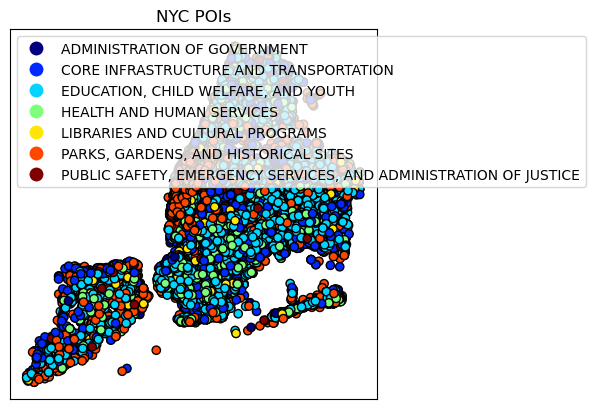

In [10]:
# https://data.cityofnewyork.us/resource/ji82-xba5.json
# TODO: kMA3pLN5r66BAnhG4hQvEr8Mi is my own token
client = Socrata("data.cityofnewyork.us", "kMA3pLN5r66BAnhG4hQvEr8Mi")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("ji82-xba5", limit=50000)

# Convert to pandas DataFrame
NYC_poi = pd.DataFrame.from_records(results)

NYC_poi = NYC_poi[NYC_poi["geometry"].notnull()]

NYC_poi['geometry'] = NYC_poi['geometry'].apply(shapely.wkt.loads)
NYC_poi = NYC_poi[['boro', 'facdomain', 'facgroup', 'facsubgrp', 'capacity', 'geometry']]

# TODO: CRS description
NYC_poi = gpd.GeoDataFrame(NYC_poi, geometry="geometry", crs="EPSG:2263")
NYC_poi = NYC_poi.to_crs(epsg=32618)
NYC_poi.plot(column="facdomain", legend=True, cmap = "jet", edgecolor="black", legend_kwds={"loc": "upper left"})
plt.title("NYC POIs")
plt.xticks([])
plt.yticks([])

plt.show()

#### Select points for analysis

In [11]:
def assign_fac_type(row):
    if row['facgroup'] in ['SCHOOLS (K-12)', 'HIGHER EDUCATION', 'VOCATIONAL AND PROPRIETARY SCHOOLS']:
        return 'Education'
    elif row['facdomain'] in ['PARKS, GARDENS, AND HISTORICAL SITES', 'LIBRARIES AND CULTURAL PROGRAMS']:
        return 'Parks, Gardens and Cultural Sites'
    elif row['facgroup'] == 'HEALTH CARE':
        return 'Public Health'
    elif row['facgroup'] in ['EMERGENCY SERVICES', 'PUBLIC SAFETY']:
        return 'Public Safety'
    else:
        return None


NYC_poi['fac_type'] = NYC_poi.apply(assign_fac_type, axis=1)
NYC_poi = NYC_poi.dropna(subset=['fac_type'], how='any')

NYC_poi.head()

,boro,facdomain,facgroup,facsubgrp,capacity,geometry,fac_type
0,STATEN ISLAND,"EDUCATION, CHILD WELFARE, AND YOUTH",SCHOOLS (K-12),PUBLIC K-12 SCHOOLS,1579,POINT (567979.616 4488486.777),Education
1,BROOKLYN,"EDUCATION, CHILD WELFARE, AND YOUTH",SCHOOLS (K-12),CHARTER K-12 SCHOOLS,0,POINT (585875.897 4495706.585),Education
2,BRONX,HEALTH AND HUMAN SERVICES,HEALTH CARE,HOSPITALS AND CLINICS,0,POINT (591105.877 4518988.575),Public Health
5,MANHATTAN,LIBRARIES AND CULTURAL PROGRAMS,CULTURAL INSTITUTIONS,OTHER CULTURAL INSTITUTIONS,0,POINT (584957.531 4510167.048),"Parks, Gardens and Cultural Sites"
7,BROOKLYN,"EDUCATION, CHILD WELFARE, AND YOUTH",SCHOOLS (K-12),PUBLIC K-12 SCHOOLS,333,POINT (589404.555 4492694.136),Education


<Axes: >

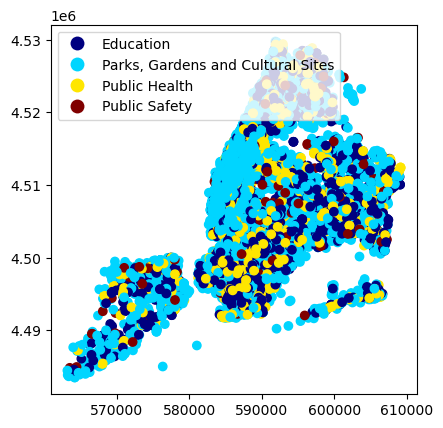

In [12]:
NYC_poi.plot(column="fac_type", legend=True, cmap = "jet", legend_kwds={"loc": "upper left"})

<a id="2_4"></a>
### 2.4 Socio-economic Indicators from ACS

#### ACS Data

- B02001 (Population by Race):

    - B02001_001E-Total Population

    - B02001_002E-White

    - B02001_002E-Black or African American

    - B02001_004E-American Indian and Alaska Native

    - B02001_005E-Asian

- B17001 (Poverty Level):
    - B17001_002E-Income in the past 12 months below poverty level

- B06011(Median Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars))
    - B06011_001E-Median Income

In [13]:
# Set API key
c = Census("c749e019b8b8dcd18a1a93b9c616c0751b78d8eb")

# Obtain Census variables from the 2022 ACS at the tract level for the NYC

# Sources: https://api.census.gov/data/2022/acs/acs5/variables.html; https://pypi.org/project/census/
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'B02001_001E', 'B02001_002E', 'B02001_004E', 'B02001_005E', 'B17001_002E', 'B06011_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2022)

In [14]:
# Create a dataframe from the census data
ny_census = pd.DataFrame(ny_census)

# Show the dataframe
display(ny_census.head())
print('Shape: ', ny_census.shape)

,NAME,B02001_001E,B02001_002E,B02001_004E,B02001_005E,B17001_002E,B06011_001E,state,county,tract
0,Census Tract 1; Albany County; New York,2259.0,750.0,0.0,30.0,641.0,22687.0,36,001,000100
1,Census Tract 2.01; Albany County; New York,2465.0,388.0,0.0,102.0,754.0,21033.0,36,001,000201
2,Census Tract 2.02; Albany County; New York,2374.0,317.0,0.0,0.0,768.0,26319.0,36,001,000202
3,Census Tract 3.01; Albany County; New York,2837.0,1005.0,0.0,4.0,921.0,29654.0,36,001,000301
4,Census Tract 3.02; Albany County; New York,3200.0,2039.0,7.0,139.0,638.0,38669.0,36,001,000302


Shape:  (5411, 10)


In [15]:
ny_census["GEOID"] = ny_census["state"] + ny_census["county"] + ny_census["tract"]


ny_census["GEOID"] = ny_census["GEOID"].astype(str)
NYC_census_tract["geoid"] = NYC_census_tract["geoid"].astype(str)

# Merge GeoDataFrame and DataFrame
NYC_census_tract = NYC_census_tract.merge(ny_census, left_on="geoid", right_on="GEOID", how="left")


# Check for missing values
columns_to_check = [
    "B02001_001E",
    "B02001_002E",
    "B02001_004E",
    "B02001_005E",
    "B17001_002E",
    "B06011_001E"
]

# Replace missing values with 0
NYC_census_tract[columns_to_check] = NYC_census_tract[columns_to_check].applymap(lambda x: max(x, 0))
NYC_census_tract.drop(columns=["NAME", 'state', 'county', 'tract'], inplace=True)
NYC_census_tract.rename(columns={"B02001_001E": "Total Population", "B02001_002E": "White Population",
                                 "B02001_004E": "Black Population", "B02001_005E": "Asian Population",
                                 "B17001_002E": "Poverty Population", "B06011_001E": "Median Income (USD)"}, inplace=True)
NYC_census_tract["Poverty Population Ratio"] = NYC_census_tract["Poverty Population"]/(NYC_census_tract["Total Population"]+0.001)
NYC_census_tract["Population Density"] = NYC_census_tract["Total Population"]/NYC_census_tract["Area (km2)"]
display(NYC_census_tract.head(20))

,borocode,boroname,geoid,geometry,Area (km2),Total Population,White Population,Black Population,Asian Population,Poverty Population,Median Income (USD),GEOID,Poverty Population Ratio,Population Density
0,1,Manhattan,36061000100,"MULTIPOLYGON (((580787.267 4504805.375, 580819...",0.171110,0.0,0.0,0.0,0.0,0.0,0.0,36061000100,0.000000,0.000000
1,1,Manhattan,36061001401,"MULTIPOLYGON (((585444.188 4507772.701, 585514...",0.093414,3165.0,2260.0,0.0,251.0,162.0,46837.0,36061001401,0.051185,33881.370808
2,1,Manhattan,36061001402,"MULTIPOLYGON (((585718.928 4508068.7, 585790.3...",0.113849,3286.0,1150.0,10.0,1099.0,946.0,44000.0,36061001402,0.287888,28862.855952
3,1,Manhattan,36061001800,"MULTIPOLYGON (((585313.281 4508223.568, 585324...",0.222764,6948.0,2619.0,42.0,3171.0,873.0,37075.0,36061001800,0.125648,31190.003758
4,1,Manhattan,36061002201,"MULTIPOLYGON (((586251.705 4508169.291, 586248...",0.161569,6748.0,2173.0,23.0,880.0,1849.0,30033.0,36061002201,0.274007,41765.435762
5,1,Manhattan,36061002601,"MULTIPOLYGON (((586405.487 4508455.689, 586373...",0.105958,4592.0,1441.0,0.0,758.0,1597.0,19983.0,36061002601,0.347779,43337.875978
6,1,Manhattan,36061002602,"MULTIPOLYGON (((586512.887 4508655.259, 586485...",0.103511,3632.0,2219.0,93.0,392.0,625.0,51757.0,36061002602,0.172081,35088.156724
7,1,Manhattan,36061002800,"MULTIPOLYGON (((586702.647 4509006.581, 586661...",0.183250,6364.0,2433.0,0.0,1357.0,1527.0,37852.0,36061002800,0.239943,34728.604538
8,1,Manhattan,36061003100,"MULTIPOLYGON (((584298.712 4508087.314, 584339...",0.204913,2667.0,1299.0,0.0,704.0,198.0,23647.0,36061003100,0.074241,13015.263648
9,1,Manhattan,36061003200,"MULTIPOLYGON (((586145.288 4508937.665, 586123...",0.216845,7523.0,5999.0,20.0,581.0,1308.0,70353.0,36061003200,0.173867,34692.924977


Text(0.5, 1.0, 'Annual Median Income (USD)')

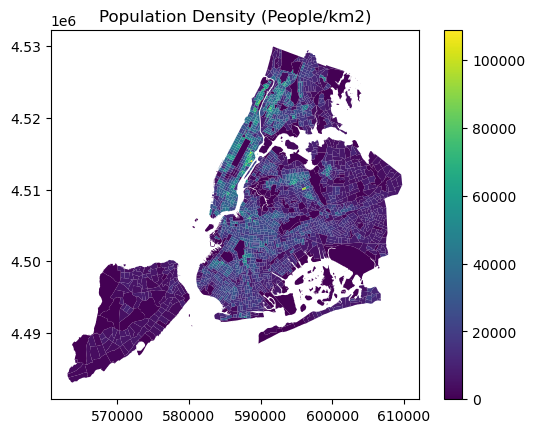

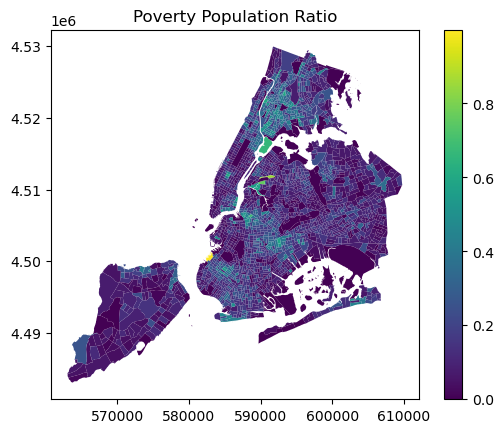

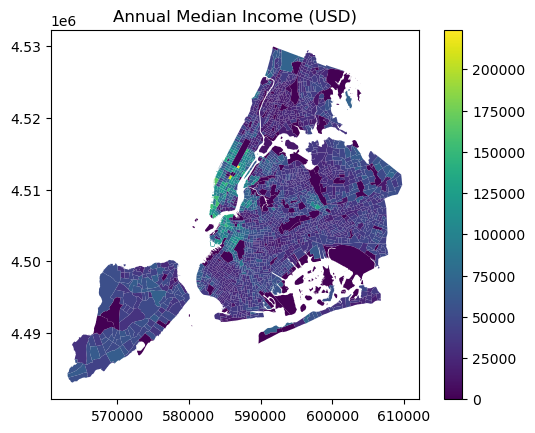

In [16]:
NYC_census_tract.plot(column="Population Density", legend=True)
plt.title("Population Density (People/km2)")

NYC_census_tract.plot(column="Poverty Population Ratio", legend=True)
plt.title("Poverty Population Ratio")

NYC_census_tract.plot(column="Median Income (USD)", legend=True)
plt.title("Annual Median Income (USD)")

<a id="2_5"></a>
### 2.5 Other Indicators Generated by Current Acquired Data

#### Road Density

In [17]:
roads_in_area = gpd.overlay(NYC_road, NYC_census_tract, how="intersection")

roads_in_area["length_km"] = roads_in_area.geometry.length / 1000
roads_in_area

,osmid,highway,name,borocode,boroname,geoid,Area (km2),Total Population,White Population,Black Population,Asian Population,Poverty Population,Median Income (USD),GEOID,Poverty Population Ratio,Population Density,geometry,length_km
0,25161349,motorway,Cross Island Parkway,4,Queens,36081099701,0.974519,2804.0,1856.0,88.0,647.0,188.0,62702.0,36081099701,0.067047,2877.315622,"LINESTRING (601994.521 4515912.963, 602041.518...",0.054216
1,25161349,motorway,Cross Island Parkway,4,Queens,36081099100,1.084231,7093.0,5042.0,0.0,892.0,423.0,56803.0,36081099100,0.059636,6541.964916,"LINESTRING (601691.23 4515738.523, 601994.521 ...",0.349879
2,25161349,motorway,Cross Island Parkway,4,Queens,36081099705,0.439166,2522.0,1203.0,94.0,840.0,154.0,37213.0,36081099705,0.061063,5742.708307,"LINESTRING (602041.518 4515939.994, 602148.812...",0.415894
3,1014007069,motorway,Cross Island Parkway,4,Queens,36081111300,0.729169,2499.0,1191.0,28.0,936.0,240.0,46910.0,36081111300,0.096038,3427.187534,"LINESTRING (604786.945 4513344.932, 604772.903...",0.042014
4,1014007069,motorway,Cross Island Parkway,4,Queens,36081138502,2.426531,109.0,99.0,0.0,3.0,30.0,0.0,36081138502,0.275227,44.920091,"LINESTRING (604906.239 4513128.015, 604814.414...",0.249160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346024,"[892127784, 122738268]",motorway,Henry Hudson Parkway,2,Bronx,36005043503,4.703662,16.0,7.0,0.0,4.0,3.0,71250.0,36005043503,0.187488,3.401605,"LINESTRING (593386.71 4528228.236, 593271.974 ...",0.252202
346025,46352244,motorway,Henry Hudson Parkway,2,Bronx,36005043503,4.703662,16.0,7.0,0.0,4.0,3.0,71250.0,36005043503,0.187488,3.401605,"LINESTRING (592929.261 4528258.438, 593131.912...",0.211409
346026,5696974,residential,East 175th Street,2,Bronx,36005016100,0.239020,4490.0,662.0,0.0,0.0,1767.0,15995.0,36005016100,0.393541,18785.068965,"LINESTRING (593971.128 4521461.045, 593960.951...",0.011178
346027,1066278122,residential,45th Street,3,Brooklyn,36047047600,0.207624,3508.0,3163.0,0.0,16.0,648.0,30123.0,36047047600,0.184721,16895.957690,"LINESTRING (586226.285 4498361.844, 586205.101...",0.026808


In [18]:

road_length_by_area = roads_in_area.groupby("GEOID")["length_km"].sum().reset_index()

NYC_census_tract = NYC_census_tract.merge(road_length_by_area, left_on="GEOID", right_on="GEOID", how="left")

NYC_census_tract["length_km"] = NYC_census_tract["length_km"].fillna(0)


Text(0.5, 1.0, 'Road Density (km/km2)')

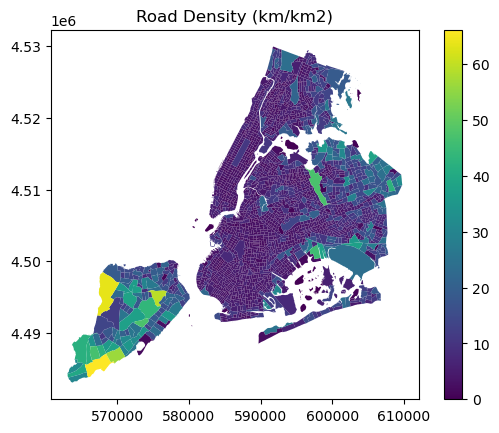

In [35]:

NYC_census_tract.plot(column="length_km", legend=True)
plt.title("Road Density (km/km2)")

#### Facility Density

In [19]:
NYC_education_poi = NYC_poi[NYC_poi["fac_type"] == "Education"]
NYC_health_poi = NYC_poi[NYC_poi["fac_type"] == "Public Health"]
NYC_safety_poi = NYC_poi[NYC_poi["fac_type"] == "Public Safety"]
NYC_parks_cultural_poi = NYC_poi[NYC_poi["fac_type"] == "Parks, Gardens and Cultural Sites"]

# 1. Education Points Density
points_within_area = gpd.sjoin(NYC_education_poi, NYC_census_tract, how="inner", predicate="within")

points_count_by_area = points_within_area.groupby("GEOID").size().reset_index(name="point_count_edu")

NYC_census_tract = NYC_census_tract.merge(points_count_by_area, on="GEOID", how="left")

NYC_census_tract["Education Density"] = NYC_census_tract["point_count_edu"].fillna(0).astype(int)

# 2. Health Points Density
points_within_area = gpd.sjoin(NYC_health_poi, NYC_census_tract, how="inner", predicate="within")

points_count_by_area = points_within_area.groupby("GEOID").size().reset_index(name="point_count_health")

NYC_census_tract = NYC_census_tract.merge(points_count_by_area, on="GEOID", how="left")

NYC_census_tract["Health Density"] = NYC_census_tract["point_count_health"].fillna(0).astype(int)

# 3. Safety Points Density
points_within_area = gpd.sjoin(NYC_safety_poi, NYC_census_tract, how="inner", predicate="within")

points_count_by_area = points_within_area.groupby("GEOID").size().reset_index(name="point_count_safety")

NYC_census_tract = NYC_census_tract.merge(points_count_by_area, on="GEOID", how="left")

NYC_census_tract["Safety Density"] = NYC_census_tract["point_count_safety"].fillna(0).astype(int)

# 4. Parks and Cultural Points Density
points_within_area = gpd.sjoin(NYC_parks_cultural_poi, NYC_census_tract, how="inner", predicate="within")

points_count_by_area = points_within_area.groupby("GEOID").size().reset_index(name="point_count_pks_cul")

NYC_census_tract = NYC_census_tract.merge(points_count_by_area, on="GEOID", how="left")

NYC_census_tract["Parks/Cultural Density"] = NYC_census_tract["point_count_pks_cul"].fillna(0).astype(int)

Text(0.5, 1.0, 'Parks and Cultural Sites Density')

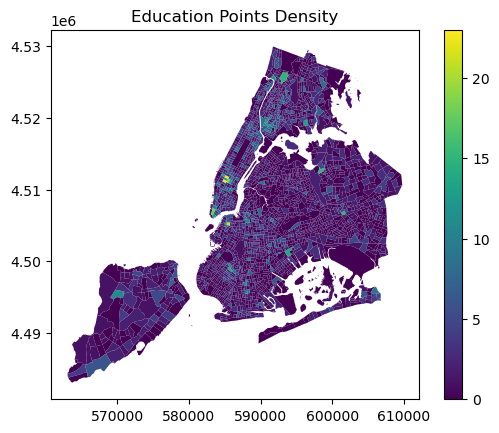

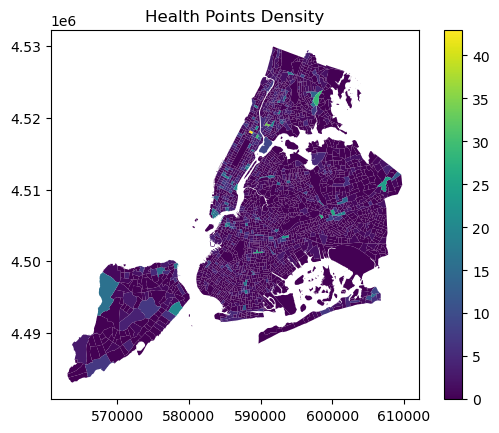

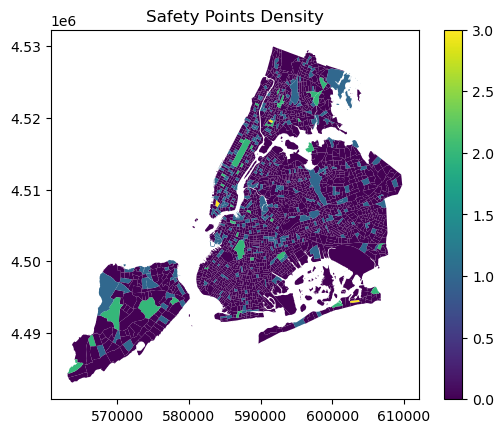

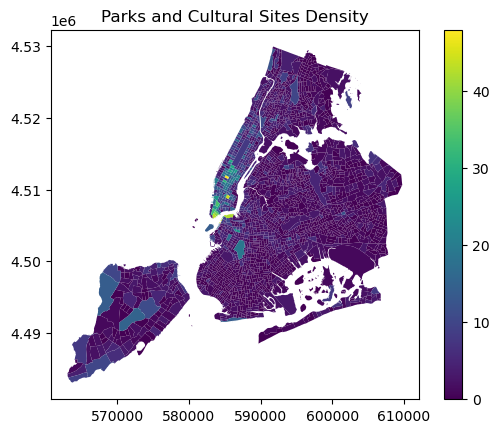

In [20]:
NYC_census_tract
NYC_census_tract.plot(column="Education Density", legend=True)
plt.title("Education Points Density")

NYC_census_tract.plot(column="Health Density", legend=True)
plt.title("Health Points Density")

NYC_census_tract.plot(column="Safety Density", legend=True)
plt.title("Safety Points Density")

NYC_census_tract.plot(column="Parks/Cultural Density", legend=True)
plt.title("Parks and Cultural Sites Density")

<a id="3"></a>
## **3. Data Visualization and Analysis**


<a id="3_1"></a>
### 3.1 Spatial Accessibility Distribution of Different Public Facilities

<Figure size 1000x800 with 0 Axes>

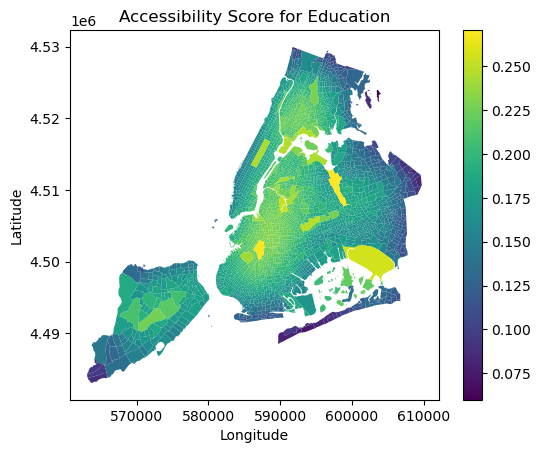

<Figure size 1000x800 with 0 Axes>

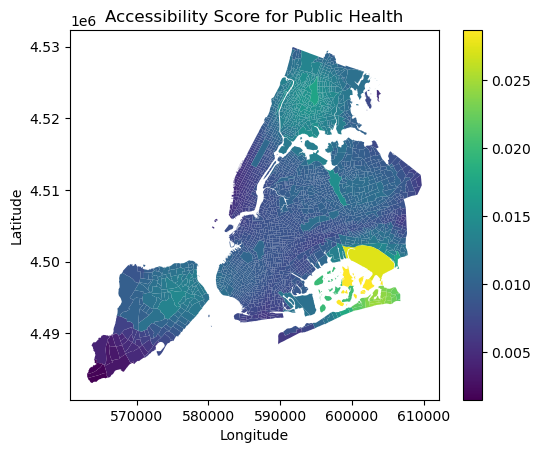

In [21]:
def gaussian_decay(distance, bandwidth):
    """
    高斯衰减函数：根据距离和带宽计算权重
    """
    return np.exp(- (distance**2) / (2 * bandwidth**2))

# Step 1: 设置参数
bandwidth = 5000  # 高斯衰减带宽，单位：米
max_distance = 10000  # 最大距离，单位：米

# Step 2: 初始化
NYC_poi['capacity'] = pd.to_numeric(NYC_poi['capacity'], errors='coerce')  # 确保容量为数值类型
facility_types = ['Education','Public Health']  # 获取所有设施类型
accessibility_columns = []  # 用于存储每个类型的可达性分数列名

# Step 3: 预计算 boro 和 fac_type 分组的平均容量
boro_fac_type_avg_capacity = (
    NYC_poi.groupby(['boro', 'fac_type'], dropna=False)['capacity']
    .mean()  # 默认跳过 NaN 值
    .reset_index()
)
boro_fac_type_avg_capacity.rename(columns={'capacity': 'avg_capacity'}, inplace=True)

# Step 4: 按设施类型计算可达性分数
for fac_type in facility_types:
    # 筛选当前类型的设施
    poi_subset = NYC_poi[NYC_poi['fac_type'] == fac_type]
    poi_subset['access_score'] = 0
    
    # Step 4.1: 计算设施的可达性分数
    for idx, facility in poi_subset.iterrows():
        distances = NYC_census_tract.geometry.distance(facility.geometry)
        within_range = distances <= max_distance
        weights = gaussian_decay(distances[within_range], bandwidth)
        weighted_population = (NYC_census_tract.loc[within_range, 'Total Population'] * weights).sum()
        
        # 替换 capacity 为 0 或缺失的情况
        capacity = facility['capacity']
        if capacity <= 0 or np.isnan(capacity):  # 如果容量为 0 或缺失
            boro = facility['boro']  # 当前设施的行政区
            fac_type = facility['fac_type']  # 当前设施的类别
            
            # 查找 boro 和 fac_type 对应的平均值
            avg_capacity_row = boro_fac_type_avg_capacity[
                (boro_fac_type_avg_capacity['boro'] == boro) &
                (boro_fac_type_avg_capacity['fac_type'] == fac_type)
            ]
            
            # 如果找到对应均值，则用均值替换；否则设为默认极小值
            if not avg_capacity_row.empty:
                capacity = avg_capacity_row['avg_capacity'].values[0]
            else:
                capacity = 1e-6  # 设置一个极小值，避免除以 0
        
        weighted_population = float(weighted_population)  # 确保为数值类型
        access_score = capacity / weighted_population if weighted_population > 0 else 0
        poi_subset.loc[idx, 'access_score'] = access_score
    
    # Step 4.2: 计算 Census Tract 的可达性分数
    accessibility_column = f'accessibility_{fac_type}'
    accessibility_columns.append(accessibility_column)
    NYC_census_tract[accessibility_column] = 0
    for idx, tract in NYC_census_tract.iterrows():
        distances = poi_subset.geometry.distance(tract.geometry)
        within_range = distances <= max_distance
        weights = gaussian_decay(distances[within_range], bandwidth)
        weighted_access_score = (poi_subset.loc[within_range, 'access_score'] * weights).sum()
        NYC_census_tract.at[idx, accessibility_column] = weighted_access_score

# Step 5: 绘制可视化
for column in accessibility_columns:
    plt.figure(figsize=(10, 8))
    NYC_census_tract.plot(column=column, legend=True, cmap='viridis')
    plt.title(f"Accessibility Score for {column.split('_')[-1]}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

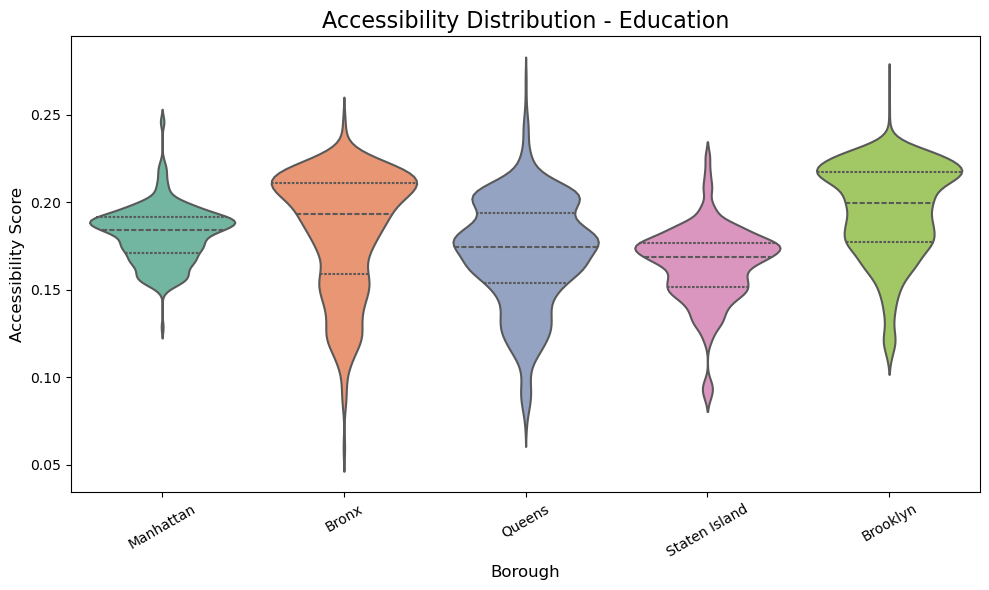

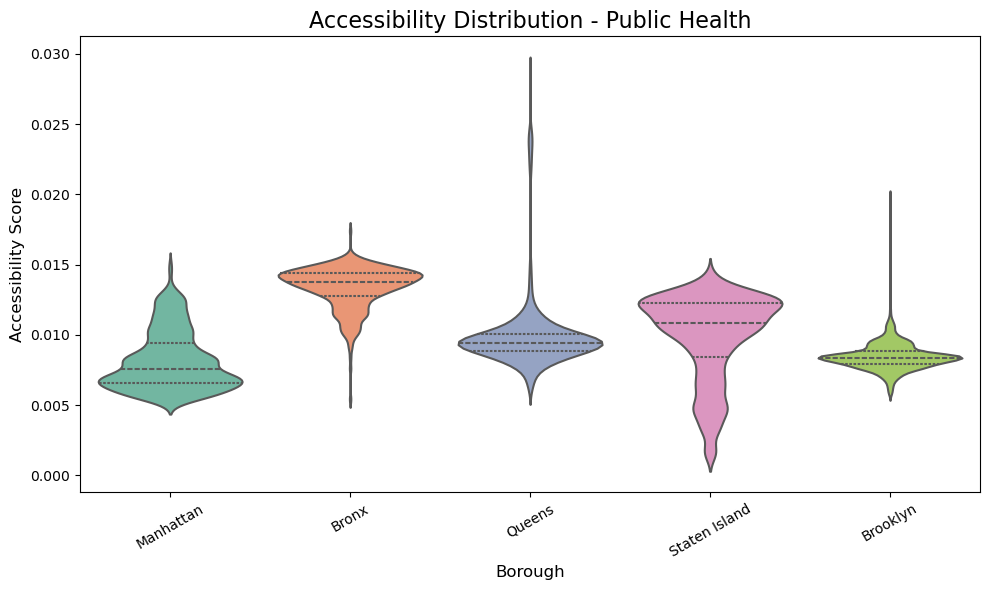

In [22]:
columns_needed = ['boroname', 'accessibility_Education', 'accessibility_Public Health']
df = NYC_census_tract[columns_needed].dropna()  # drop Na
df_education = df[['boroname', 'accessibility_Education']].rename(columns={'accessibility_Education': 'Value'})
df_public_health = df[['boroname', 'accessibility_Public Health']].rename(columns={'accessibility_Public Health': 'Value'})

# Education
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_education, x='boroname', y='Value', inner="quartile",  # set inner to make the graph clear
    linewidth=1.5, scale='width', palette="Set2", bw=0.2  # control the width
)
plt.title("Accessibility Distribution - Education", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Accessibility Score", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Public Health
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_public_health, x='boroname', y='Value', inner="quartile",
    linewidth=1.5, scale='width', palette="Set2", bw=0.2
)
plt.title("Accessibility Distribution - Public Health", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Accessibility Score", fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

<a id="3_2"></a>
### 3.2 Equity Assessment of Different Boroughs

In [23]:
NYC_census_tract.head(10)

,borocode,boroname,geoid,geometry,Area (km2),Total Population,White Population,Black Population,Asian Population,Poverty Population,Median Income (USD),GEOID,Poverty Population Ratio,Population Density,length_km,point_count_edu,Education Density,point_count_health,Health Density,point_count_safety,Safety Density,point_count_pks_cul,Parks/Cultural Density,accessibility_Education,accessibility_Public Health
0,1,Manhattan,36061000100,"MULTIPOLYGON (((580787.267 4504805.375, 580819...",0.171110,0.0,0.0,0.0,0.0,0.0,0.0,36061000100,0.000000,0.000000,0.000000,NaN,0,NaN,0,NaN,0,NaN,0,0.128676,0.005544
1,1,Manhattan,36061001401,"MULTIPOLYGON (((585444.188 4507772.701, 585514...",0.093414,3165.0,2260.0,0.0,251.0,162.0,46837.0,36061001401,0.051185,33881.370808,2.160050,NaN,0,7.0,7,NaN,0,4.0,4,0.193922,0.006775
2,1,Manhattan,36061001402,"MULTIPOLYGON (((585718.928 4508068.7, 585790.3...",0.113849,3286.0,1150.0,10.0,1099.0,946.0,44000.0,36061001402,0.287888,28862.855952,2.951788,2.0,2,1.0,1,NaN,0,13.0,13,0.193863,0.006822
3,1,Manhattan,36061001800,"MULTIPOLYGON (((585313.281 4508223.568, 585324...",0.222764,6948.0,2619.0,42.0,3171.0,873.0,37075.0,36061001800,0.125648,31190.003758,7.418625,5.0,5,13.0,13,1.0,1,19.0,19,0.190209,0.006654
4,1,Manhattan,36061002201,"MULTIPOLYGON (((586251.705 4508169.291, 586248...",0.161569,6748.0,2173.0,23.0,880.0,1849.0,30033.0,36061002201,0.274007,41765.435762,2.714180,4.0,4,NaN,0,NaN,0,6.0,6,0.199299,0.007070
5,1,Manhattan,36061002601,"MULTIPOLYGON (((586405.487 4508455.689, 586373...",0.105958,4592.0,1441.0,0.0,758.0,1597.0,19983.0,36061002601,0.347779,43337.875978,2.477322,4.0,4,2.0,2,NaN,0,12.0,12,0.198027,0.007001
6,1,Manhattan,36061002602,"MULTIPOLYGON (((586512.887 4508655.259, 586485...",0.103511,3632.0,2219.0,93.0,392.0,625.0,51757.0,36061002602,0.172081,35088.156724,1.679316,NaN,0,1.0,1,1.0,1,14.0,14,0.198015,0.007031
7,1,Manhattan,36061002800,"MULTIPOLYGON (((586702.647 4509006.581, 586661...",0.183250,6364.0,2433.0,0.0,1357.0,1527.0,37852.0,36061002800,0.239943,34728.604538,3.535888,2.0,2,1.0,1,NaN,0,10.0,10,0.200603,0.007205
8,1,Manhattan,36061003100,"MULTIPOLYGON (((584298.712 4508087.314, 584339...",0.204913,2667.0,1299.0,0.0,704.0,198.0,23647.0,36061003100,0.074241,13015.263648,2.930791,NaN,0,5.0,5,1.0,1,27.0,27,0.176138,0.006082
9,1,Manhattan,36061003200,"MULTIPOLYGON (((586145.288 4508937.665, 586123...",0.216845,7523.0,5999.0,20.0,581.0,1308.0,70353.0,36061003200,0.173867,34692.924977,4.179589,5.0,5,NaN,0,NaN,0,15.0,15,0.195069,0.006954


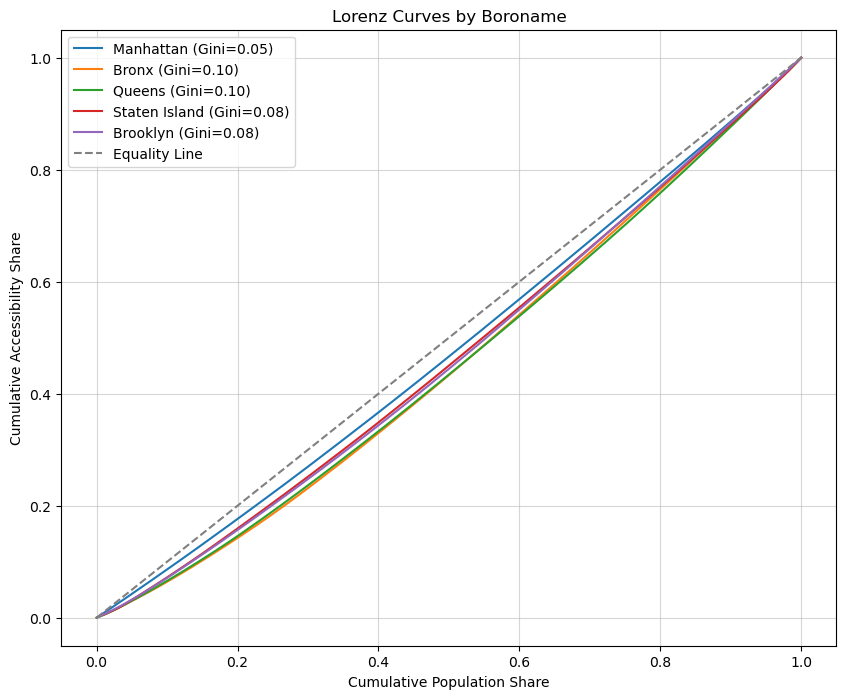

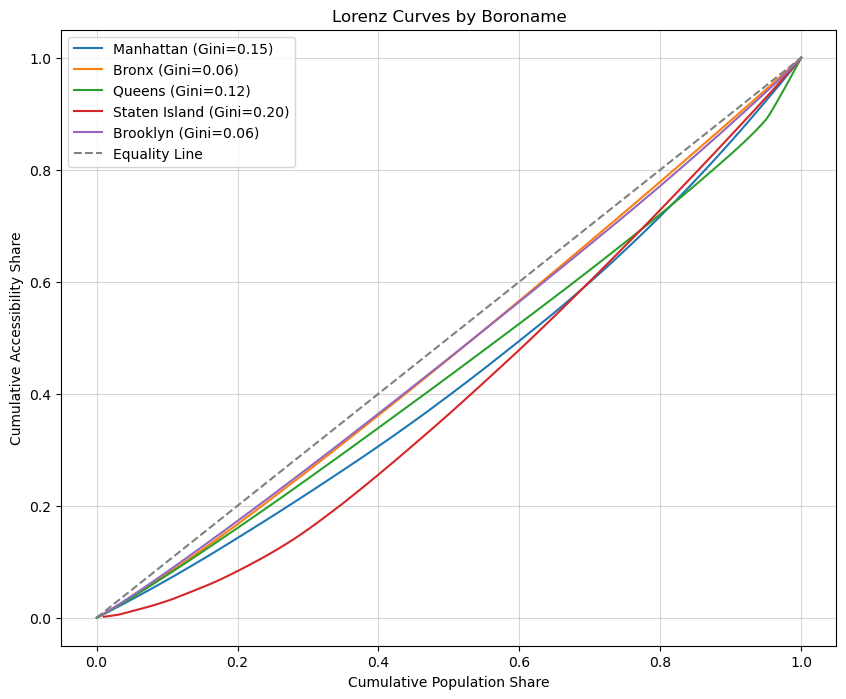

In [25]:
def weighted_gini(accessibility, population):
    """
    计算加权基尼系数
    :param accessibility: 一维数组，可达性数据
    :param population: 一维数组，人口数据
    :return: 基尼系数，累积人口比例，累积可达性比例
    """
    # 排序
    sorted_indices = np.argsort(accessibility)
    accessibility = accessibility[sorted_indices]
    population = population[sorted_indices]
    
    # 累积值
    cum_population = np.cumsum(population)
    total_population = cum_population[-1]
    cum_population_ratio = cum_population / total_population
    
    cum_accessibility = np.cumsum(accessibility * population)
    total_accessibility = cum_accessibility[-1]
    cum_accessibility_ratio = cum_accessibility / total_accessibility
    
    # 基尼系数
    gini = 1 - 2 * np.sum(cum_accessibility_ratio[:-1] * np.diff(cum_population_ratio))
    return gini, cum_population_ratio, cum_accessibility_ratio

def plot_lorenz_curves(data, boroname_col, accessibility_col, population_col):
    """
    为每个地区绘制洛伦兹曲线
    :param data: 包含数据的 DataFrame
    :param boroname_col: 地区名称的列名
    :param accessibility_col: 可达性列名
    :param population_col: 人口列名
    """
    plt.figure(figsize=(10, 8))
    unique_boros = data[boroname_col].unique()
    
    for boro in unique_boros:
        # 筛选当前地区数据
        boro_data = data[data[boroname_col] == boro]
        accessibility = boro_data[accessibility_col].values
        population = boro_data[population_col].values
        
        # 计算基尼系数和累积比例
        gini, cum_population_ratio, cum_accessibility_ratio = weighted_gini(accessibility, population)
        plt.plot(cum_population_ratio, cum_accessibility_ratio, label=f"{boro} (Gini={gini:.2f})")
    
    # 添加完全平等线
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equality Line")
    plt.title("Lorenz Curves by Boroname")
    plt.xlabel("Cumulative Population Share")
    plt.ylabel("Cumulative Accessibility Share")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


# 绘制洛伦兹曲线
plot_lorenz_curves(NYC_census_tract, "boroname", "accessibility_Education", "Total Population")
plot_lorenz_curves(NYC_census_tract, "boroname", "accessibility_Public Health", "Total Population")

<a id="3_3"></a>
### 3.3 Equity Assessment of Different Demographic Groups

#### Between Different Income status

In [26]:
# 计算四分位数
quartiles = NYC_census_tract['Median Income (USD)'].quantile([0.25, 0.5, 0.75])

# 定义分类函数
def classify_income(row):
    if row <= quartiles[0.25]:
        return "Low Income"
    elif quartiles[0.25] < row <= quartiles[0.5]:
        return "Lower-Middle Income"
    elif quartiles[0.5] < row <= quartiles[0.75]:
        return "Upper-Middle Income"
    else:
        return "High Income"

# 创建新列并分类
NYC_census_tract['Income Status'] = NYC_census_tract['Median Income (USD)'].apply(classify_income)


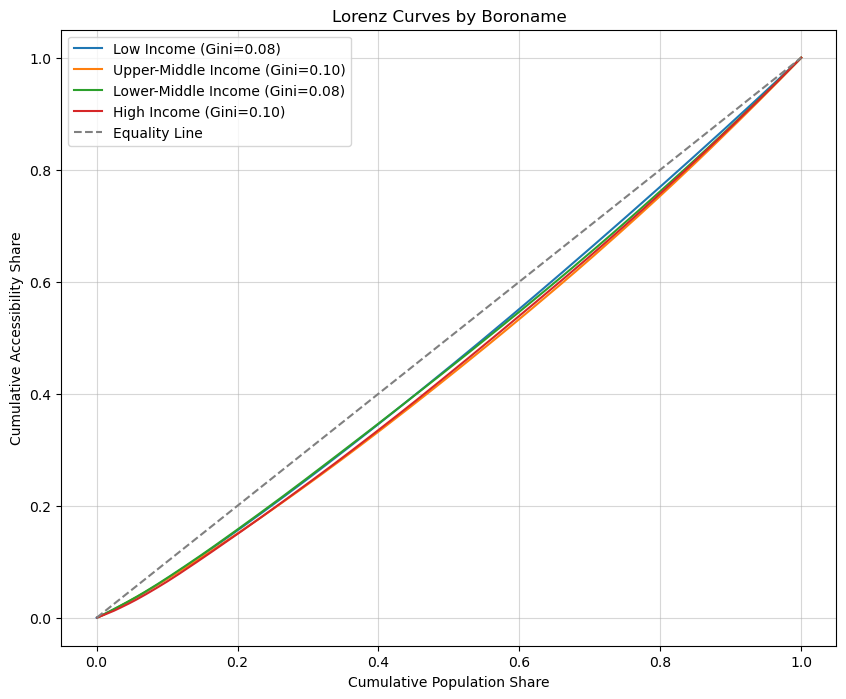

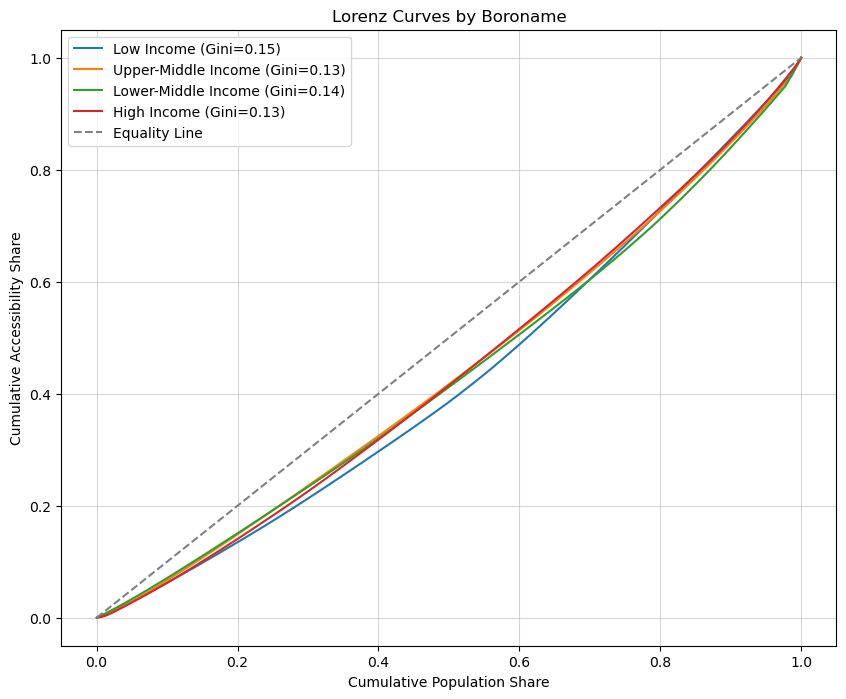

In [27]:
plot_lorenz_curves(NYC_census_tract, "Income Status", "accessibility_Education", "Total Population")
plot_lorenz_curves(NYC_census_tract, "Income Status", "accessibility_Public Health", "Total Population")

#### Between different races


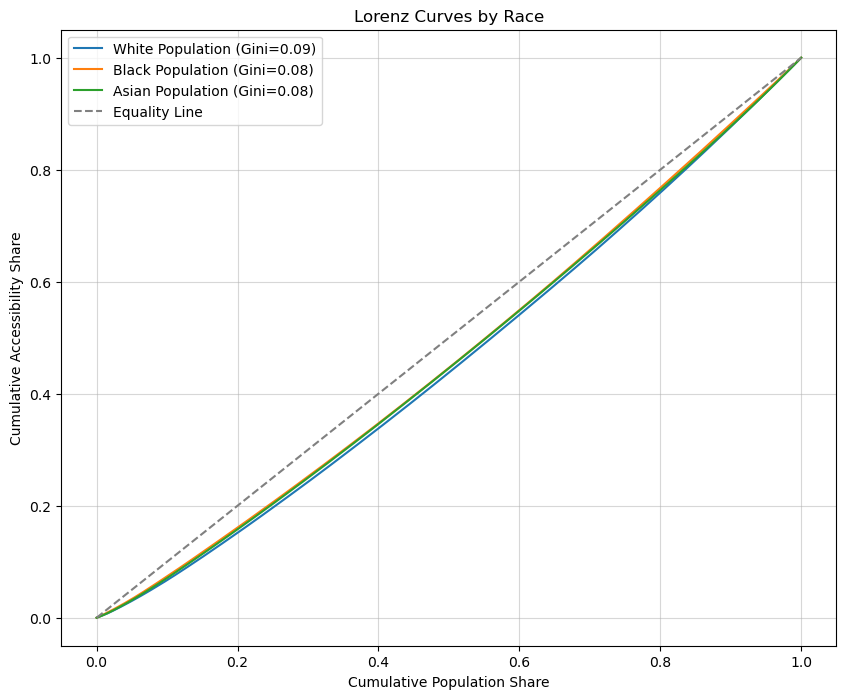

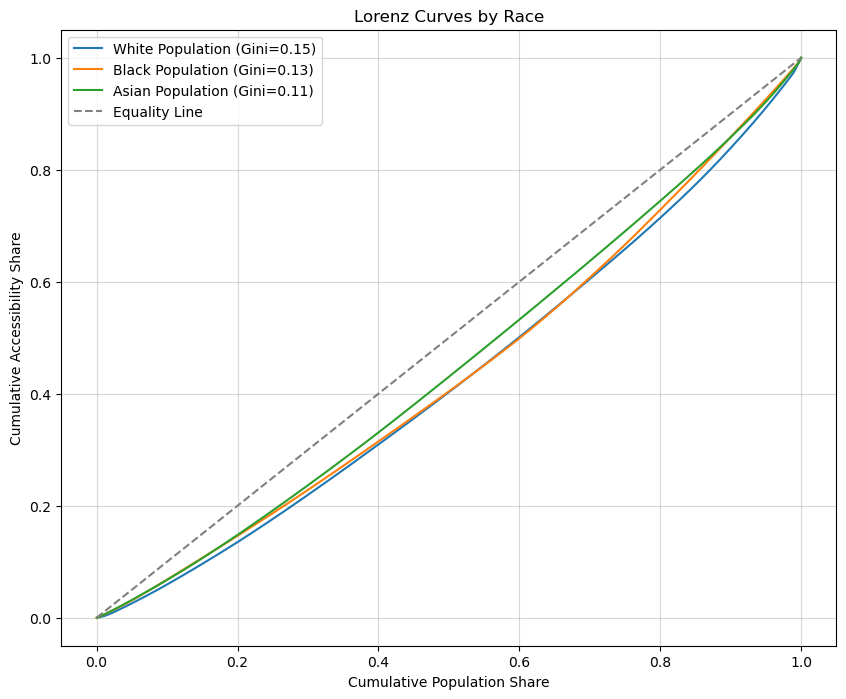

In [28]:
def weighted_gini(accessibility, population):
    """
    计算加权基尼系数
    :param accessibility: 一维数组，可达性数据
    :param population: 一维数组，人口数据
    :return: 基尼系数，累积人口比例，累积可达性比例
    """
    # 排序
    sorted_indices = np.argsort(accessibility)
    accessibility = accessibility[sorted_indices]
    population = population[sorted_indices]
    
    # 累积值
    cum_population = np.cumsum(population)
    total_population = cum_population[-1]
    cum_population_ratio = cum_population / total_population
    
    cum_accessibility = np.cumsum(accessibility * population)
    total_accessibility = cum_accessibility[-1]
    cum_accessibility_ratio = cum_accessibility / total_accessibility
    
    # 基尼系数
    gini = 1 - 2 * np.sum(cum_accessibility_ratio[:-1] * np.diff(cum_population_ratio))
    return gini, cum_population_ratio, cum_accessibility_ratio

def plot_lorenz_by_race(data, accessibility_col, race_cols):
    """
    按人种绘制洛伦兹曲线
    :param data: 包含数据的 DataFrame
    :param accessibility_col: 可达性列名
    :param race_cols: 各人种人口列名
    """
    plt.figure(figsize=(10, 8))
    
    for race in race_cols:
        # 提取人种对应数据
        accessibility = data[accessibility_col].values
        population = data[race].values
        
        # 计算基尼系数和累积比例
        gini, cum_population_ratio, cum_accessibility_ratio = weighted_gini(accessibility, population)
        plt.plot(cum_population_ratio, cum_accessibility_ratio, label=f"{race} (Gini={gini:.2f})")
    
    # 添加完全平等线
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Equality Line")
    plt.title("Lorenz Curves by Race")
    plt.xlabel("Cumulative Population Share")
    plt.ylabel("Cumulative Accessibility Share")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()

# 调用函数，绘制不同人种的洛伦兹曲线
race_columns = ["White Population", "Black Population", "Asian Population"]
plot_lorenz_by_race(NYC_census_tract, "accessibility_Education", race_columns)
plot_lorenz_by_race(NYC_census_tract, "accessibility_Public Health", race_columns)

<a id="3_4"></a>
### 3.4 Evaluation of Socio-economic Factors’ Impact on Facility Accessibility

In [32]:
NYC_census_tract

,borocode,boroname,geoid,geometry,Area (km2),Total Population,White Population,Black Population,Asian Population,Poverty Population,Median Income (USD),GEOID,Poverty Population Ratio,Population Density,length_km,point_count_edu,Education Density,point_count_health,Health Density,point_count_safety,Safety Density,point_count_pks_cul,Parks/Cultural Density,accessibility_Education,accessibility_Public Health,Income Status
0,1,Manhattan,36061000100,"MULTIPOLYGON (((580787.267 4504805.375, 580819...",0.171110,0.0,0.0,0.0,0.0,0.0,0.0,36061000100,0.000000,0.000000,0.000000,NaN,0,NaN,0,NaN,0,NaN,0,0.128676,0.005544,Low Income
1,1,Manhattan,36061001401,"MULTIPOLYGON (((585444.188 4507772.701, 585514...",0.093414,3165.0,2260.0,0.0,251.0,162.0,46837.0,36061001401,0.051185,33881.370808,2.160050,NaN,0,7.0,7,NaN,0,4.0,4,0.193922,0.006775,Upper-Middle Income
2,1,Manhattan,36061001402,"MULTIPOLYGON (((585718.928 4508068.7, 585790.3...",0.113849,3286.0,1150.0,10.0,1099.0,946.0,44000.0,36061001402,0.287888,28862.855952,2.951788,2.0,2,1.0,1,NaN,0,13.0,13,0.193863,0.006822,Upper-Middle Income
3,1,Manhattan,36061001800,"MULTIPOLYGON (((585313.281 4508223.568, 585324...",0.222764,6948.0,2619.0,42.0,3171.0,873.0,37075.0,36061001800,0.125648,31190.003758,7.418625,5.0,5,13.0,13,1.0,1,19.0,19,0.190209,0.006654,Lower-Middle Income
4,1,Manhattan,36061002201,"MULTIPOLYGON (((586251.705 4508169.291, 586248...",0.161569,6748.0,2173.0,23.0,880.0,1849.0,30033.0,36061002201,0.274007,41765.435762,2.714180,4.0,4,NaN,0,NaN,0,6.0,6,0.199299,0.007070,Lower-Middle Income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,1,Manhattan,36061000600,"MULTIPOLYGON (((585290.21 4507544.361, 585365....",0.241116,10751.0,1225.0,56.0,5567.0,4175.0,16069.0,36061000600,0.388336,44588.474242,5.838195,2.0,2,14.0,14,NaN,0,10.0,10,0.196492,0.006896,Low Income
2321,3,Brooklyn,36047044700,"MULTIPOLYGON (((591296.144 4506884.219, 591205...",0.162693,2594.0,1236.0,0.0,76.0,1020.0,27326.0,36047044700,0.393215,15944.128420,3.770010,NaN,0,NaN,0,NaN,0,1.0,1,0.217028,0.008574,Low Income
2322,4,Queens,36081053901,"MULTIPOLYGON (((591585.96 4507517.313, 591627....",0.440412,4367.0,2212.0,21.0,797.0,359.0,46576.0,36081053901,0.082207,9915.723522,9.475052,1.0,1,1.0,1,NaN,0,5.0,5,0.225994,0.009163,Upper-Middle Income
2323,3,Brooklyn,36047053700,"MULTIPOLYGON (((588075.43 4506068.964, 588096....",0.167367,4289.0,4186.0,0.0,31.0,1775.0,19357.0,36047053700,0.413849,25626.391232,5.395216,9.0,9,5.0,5,NaN,0,4.0,4,0.225336,0.008095,Low Income


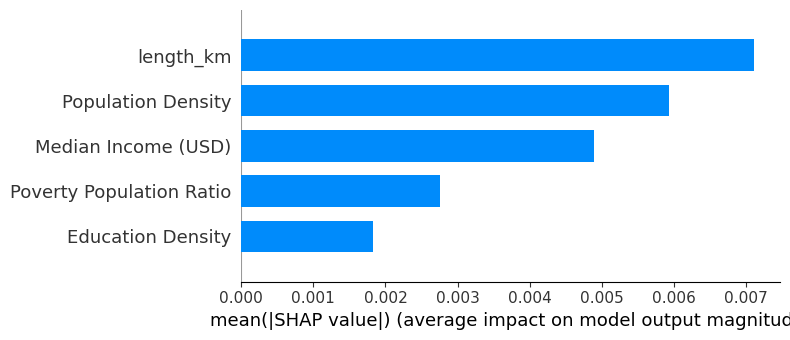

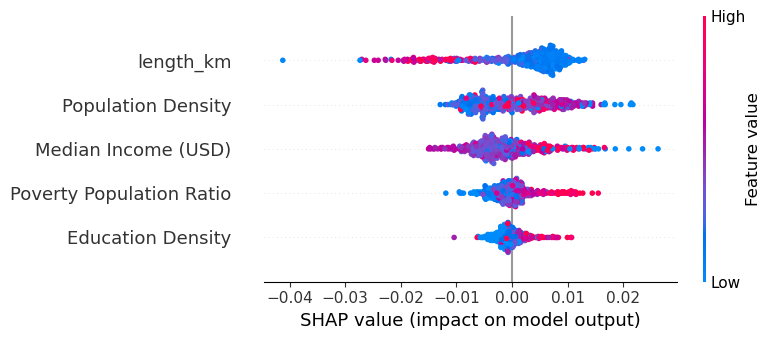

In [37]:
# 假设你的数据存储在 NYC_census_tract DataFrame 中
# 确认需要的列
columns = ['accessibility_Education', 'Median Income (USD)', 'Population Density', 
           'Education Density', 'Poverty Population Ratio', 'length_km']
data = NYC_census_tract[columns]

# 数据预处理：去除缺失值
data = data.dropna()

# 定义因变量和自变量
X = data[['Median Income (USD)', 'Population Density', 'Education Density', 
          'Poverty Population Ratio', 'length_km']]
y = data['accessibility_Education']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林回归模型
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 使用 SHAP 解释模型
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 绘制 SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # 柱状图显示变量重要性
shap.summary_plot(shap_values, X_test)                  # 综合图显示变量与预测值关系


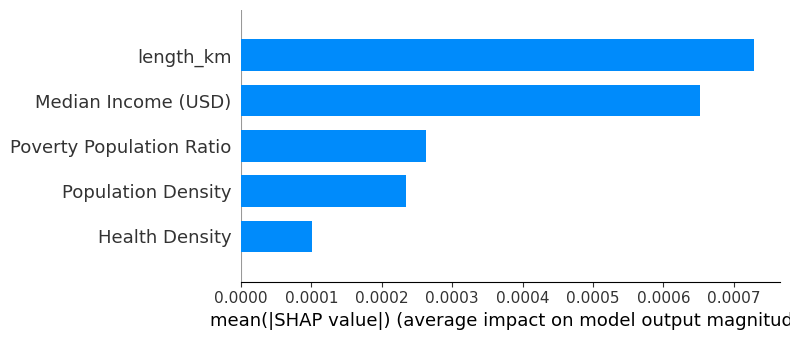

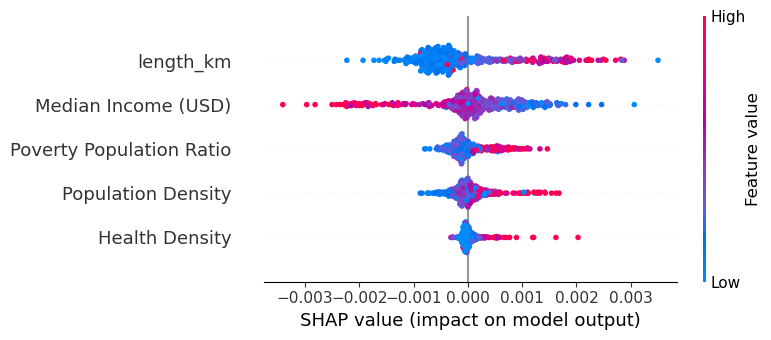

In [35]:
# 假设你的数据存储在 NYC_census_tract DataFrame 中
# 确认需要的列
columns = ['accessibility_Public Health', 'Median Income (USD)', 'Population Density', 
           'Health Density', 'Poverty Population Ratio', 'length_km']
data = NYC_census_tract[columns]

# 数据预处理：去除缺失值
data = data.dropna()

# 定义因变量和自变量
X = data[['Median Income (USD)', 'Population Density', 'Health Density', 
          'Poverty Population Ratio', 'length_km']]
y = data['accessibility_Public Health']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练随机森林回归模型
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 使用 SHAP 解释模型
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# 绘制 SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")  # 柱状图显示变量重要性
shap.summary_plot(shap_values, X_test)                  # 综合图显示变量与预测值关系


<a id="4"></a>
## **4. Conclusion**

<a id="5"></a>
## References

- United Nations. (2018). *World Urbanization Prospects 2018*. Population Division, United Nations. https://www.un.org/development/desa/pd/news/world-urbanization-prospects-2018
- Sarkar, S., Cottineau-Mugadza, C., & Wolf, L. J. (2024). Spatial inequalities and cities: A review. *Environment and Planning B: Urban Analytics and City Science*, 51(7), 1391-1407. https://doi.org/10.1177/23998083241263422

- Xu, R., Yue, W., Wei, F., Yang, G., Chen, Y., & Pan, K. (2022). Inequality of public facilities between urban and rural areas and its driving factors in ten cities of China. *Scientific Reports*. https://doi.org/10.1038/s41598-022-17569-2

- Baghestani, A., Nikbakht, M., Kucheva, Y., & Afshar, A. (2024). Assessing spatial and racial equity of subway accessibility: Case study of New York City. *Cities*, 155, 105489. https://doi.org/10.1016/j.cities.2024.105489